Credit [DNN tutorial](https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a)

In [1]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
FILE_PATH = '/content/drive/MyDrive/CV_Project_Workspace/Project_Code/DNN_multimodal_data/'
ACTORS = ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 
          'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 
          'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 
          'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
EMOTIONS = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

In [5]:
# Load preprocessed data for DNN
fetched_data = np.zeros([11307, 4624])
labels = np.zeros(11307)
data_index = 0

for actor in ACTORS:
  file_path = FILE_PATH + actor + '/'
  for dirname, _, files in os.walk(file_path):
    for CURRENT_FILE in files:
      if CURRENT_FILE[21:] != 'face.csv':
        continue
      VIDEO_PATH = os.path.join(dirname, CURRENT_FILE)
      AUDIO_PATH = dirname+CURRENT_FILE[:21]+'audio.csv'

      video = []
      audio = []
      with open(VIDEO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        video = np.array(data)
      for i in range(video.shape[0]):
        fetched_data[data_index] = video[i]
        labels[data_index] = np.array(int(CURRENT_FILE[7])-1)
        data_index += 1

In [50]:
print(labels[11300])

7.0


In [51]:
import random

example_nums = fetched_data.shape[0]
train_example_nums = int(0.8 * example_nums)
test_example_nums = int(0.1 * example_nums)
validation_example_nums = example_nums - train_example_nums - test_example_nums

random_ids = [i for i in range(example_nums)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:train_example_nums+test_example_nums]
random_validation_ids = random_ids[train_example_nums+test_example_nums:]

print(len(random_train_ids), len(random_test_ids), len(random_validation_ids))


X_train = torch.as_tensor(fetched_data[random_train_ids][:,:])
Y_train = torch.as_tensor(labels[random_train_ids]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids][:,:])
Y_test = torch.as_tensor(labels[random_test_ids]).type(torch.int64)

X_vali = torch.as_tensor(fetched_data[random_validation_ids][:,:])
Y_vali = torch.as_tensor(labels[random_validation_ids]).type(torch.int64)


9045 1130 1132


In [52]:
np.shape(X_vali)

torch.Size([1132, 4624])

In [54]:
np.shape(Y_vali)

torch.Size([1132])

In [55]:
class FaceDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.faces = X

  def __len__(self):
    return len(self.faces)

  def __getitem__(self, index):
    face = self.faces[index]
    label = self.labels[index]
    return face, label

In [56]:
train_dataset = FaceDataset(X_train, Y_train)
test_dataset = FaceDataset(X_test, Y_test)
validation_dataset = FaceDataset(X_vali, Y_vali)

print(min(Y_train), max(Y_train))
print(Y_test)

tensor(0) tensor(7)
tensor([6, 6, 1,  ..., 4, 1, 2])


In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [57]:
class EmotionClassificationBase(nn.Module):
    def training_step(self, batch):
        faces, labels = batch 
        out = self(faces.type(torch.FloatTensor).to(device))                  # Generate predictions
        print(out)
        loss = F.cross_entropy(out, labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        faces, labels = batch
        out = self(faces.type(torch.FloatTensor).to(device))                    # Generate predictions
        print(out)
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [58]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [59]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [60]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [61]:
class DNN(EmotionClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(4624, 512)
    self.fc2 = torch.nn.Linear(512, 512)
    self.fc3 = torch.nn.Linear(512, 512)
    self.fc4 = torch.nn.Linear(512, 512)
    self.fc5 = torch.nn.Linear(512, 512)
    self.fc6 = torch.nn.Linear(512, 8)


  def forward(self, x: torch.Tensor) -> torch.Tensor:     
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    return x

In [62]:
model = DNN()
model.to(device)

DNN(
  (fc1): Linear(in_features=4624, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=8, bias=True)
)

In [63]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4)
val_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size*4)

In [64]:
history = [evaluate(model, val_dataloader)]
history

tensor([[ 0.0716,  0.3600,  0.4580,  ...,  0.8365,  0.1099, -0.2312],
        [ 0.0593,  0.4415,  0.4988,  ...,  0.8954,  0.0909, -0.2701],
        [ 0.1088,  0.3824,  0.4992,  ...,  0.9230,  0.1015, -0.2050],
        ...,
        [ 0.1108,  0.3876,  0.5368,  ...,  0.9496,  0.1325, -0.2459],
        [ 0.0957,  0.3358,  0.4405,  ...,  0.8080,  0.1011, -0.1839],
        [ 0.1035,  0.4044,  0.4816,  ...,  0.8146,  0.0851, -0.2480]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0494,  0.3664,  0.4821,  ...,  0.8395,  0.0971, -0.2360],
        [ 0.0617,  0.3720,  0.4482,  ...,  0.8117,  0.1008, -0.2299],
        [ 0.0882,  0.4239,  0.4557,  ...,  0.9020,  0.0866, -0.2004],
        ...,
        [ 0.0885,  0.4595,  0.5200,  ...,  0.9664,  0.1245, -0.2801],
        [ 0.0525,  0.3986,  0.3345,  ...,  0.7443,  0.1227, -0.2095],
        [ 0.0455,  0.4660,  0.4396,  ...,  0.8793,  0.0918, -0.2280]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0879,  0.4695,  0.45

[{'val_loss': 2.1324450969696045, 'val_acc': 0.1281185746192932}]

In [65]:
history += fit(20, 0.0001 , model, train_dataloader, val_dataloader)

Streaming output truncated to the last 5000 lines.
        [-1.6683, -1.7579, -2.4711,  1.2230,  1.2093,  1.5129,  2.4296,  0.9729],
        [-2.3193, -2.7990, -3.1776,  1.0610,  1.6608,  2.5792,  3.4307,  1.3821],
        [ 0.2793,  1.6114, -0.4376,  0.5816,  0.0386,  0.2403,  0.0724, -0.1835],
        [-0.1937,  0.4518, -0.8480,  0.7004,  0.2745,  0.5774,  0.2989,  0.4169],
        [-2.4562,  3.2295,  4.5184, -0.7266,  0.1885, -0.1884, -0.7279, -0.1179],
        [-0.5315,  0.1190, -0.7248,  0.8182,  0.3170,  0.5799,  0.4647,  0.4777],
        [ 0.0062,  1.2242,  0.1854,  0.9417, -0.3196,  0.0050, -0.3368,  0.3156],
        [-1.1794,  0.3397, -0.7025,  0.6526,  0.3639,  0.5367,  1.4487,  0.3386],
        [-0.6343,  1.9184,  0.6120,  0.1110, -0.0784,  0.3046,  0.1139, -0.0895],
        [ 0.0317,  3.0667,  1.8031,  0.5473, -0.7375, -0.2394, -1.6289,  0.1077],
        [-0.4808,  1.1737,  0.9223,  1.1456, -0.5784, -0.1697, -0.1752,  0.3082],
        [-2.5455, -2.0704, -2.5194,  0.3681,  2

In [66]:
history += fit(20, 0.00001 , model, train_dataloader, val_dataloader)

Streaming output truncated to the last 5000 lines.
        [ 1.7224e+00,  1.1681e+00, -4.9451e-01,  4.2869e-01,  1.1758e-01,
          2.0147e-01, -1.7837e+00,  8.9473e-01],
        [-1.3562e+00, -3.5776e+00, -3.4675e+00, -5.8167e-01,  3.9434e+00,
          3.2520e+00, -9.5513e-01,  3.3087e+00],
        [-3.4105e+00, -3.9794e-01,  1.9589e+00,  7.8873e-01,  6.7565e-01,
          8.1284e-01,  1.2829e+00,  8.6712e-01],
        [ 1.0577e+00, -1.9806e-01, -1.5867e+00,  9.9454e-01,  5.9210e-01,
          6.7032e-01, -8.2190e-01,  8.7412e-01],
        [ 7.6080e-01,  6.4382e-01, -1.4893e+00,  6.2503e-01,  5.9603e-01,
          7.8695e-01, -1.1282e-01,  5.1601e-01],
        [-1.4310e+00, -1.8200e+00, -2.4570e+00,  1.1985e+00,  1.8303e+00,
          9.6188e-01,  1.4431e+00,  1.1842e+00],
        [ 9.0252e-01,  2.2958e+00,  4.6801e-01,  3.0362e-01, -2.9711e-01,
         -5.2368e-02, -1.3155e+00,  3.5307e-01],
        [-3.7986e+00, -3.0279e+00, -2.1261e+00,  1.2093e+00,  2.3785e+00,
          1.27

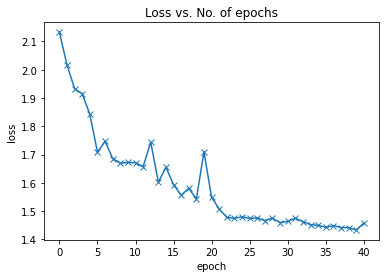

In [67]:
plot_losses(history)

In [68]:
plot_accuracies(history)

In [69]:
evaluate(model, test_dataloader)

tensor([[-7.4558e-01,  2.3948e-01, -1.4050e+00,  ...,  1.6681e+00,
          9.4254e-01,  5.1240e-01],
        [-3.6914e+00, -2.3564e-01,  1.8548e+00,  ..., -4.0316e-01,
          2.3972e+00,  7.0915e-01],
        [-4.5068e-01,  2.0629e+00,  8.7127e-01,  ...,  7.1583e-01,
         -6.8036e-01,  2.8475e-01],
        ...,
        [ 4.9144e-01,  2.4882e+00,  1.3325e+00,  ...,  1.0299e-01,
         -2.1058e+00,  7.4358e-01],
        [-3.1146e+00,  1.9789e+00,  4.9179e+00,  ...,  1.1665e-03,
         -9.8965e-01,  5.6547e-01],
        [ 8.6269e-01,  6.1723e-01, -8.3327e-01,  ...,  2.1958e-01,
         -6.6630e-01,  5.4520e-01]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.1320, -1.5067, -1.8586,  ...,  2.8838, -1.4088,  2.3443],
        [-3.4212,  1.6944,  5.0952,  ...,  0.4441, -1.1291,  0.8697],
        [ 0.4345, -0.9747, -1.3459,  ...,  2.3885, -2.0737,  2.5205],
        ...,
        [ 1.3618,  1.4477, -0.3882,  ...,  0.2356, -1.3052,  0.5536],
        [-0.9674,  3.0675,  2.49

{'val_loss': 1.4873931407928467, 'val_acc': 0.4348630905151367}

In [70]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CV_Project_Workspace/Project_Code/late_fusion_DNN/video.pth')

# Use trained model to perform predictions on datasets